In [29]:
import numpy as np
import pickle as pkl
from pprint import pprint
import os
import matplotlib
import matplotlib.pyplot as plt
plt.ion()


path_source_files = '/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid'

In [30]:
# Get list of all pickle files in the target directory
filenames = os.listdir(path_source_files)
filenames = [fn for fn in filenames if fn.endswith('.pkl')]

In [31]:
filenames

['20230821_20h36m_230110_CHD8Samples_4AP&BiccExposure_~3weeksAfter_DA.pkl',
 '20230821_20h36m_230112_CHD8Samples_4AP&BiccExposure_~3weeksAfter_DA.pkl',
 '20230821_20h36m_221215_CHD8Samples_DA.pkl',
 '20230821_20h36m_230112_CHD8Samples_4AP&BiccExposure_~3weeksAfter_HFStimulation_DA.pkl',
 '20230821_20h36m_230112_CHD8Samples_4AP&BiccExposure_~3weeksAfter_Post_HFStimulation_DA.pkl',
 '20230821_20h36m_230126_CHD8Samples_4AP&BiccExposure__6weeksAfter_DA.pkl',
 '20230821_20h36m_221218_CHD8Samples_Network_Baseline_b4_Chemicals_DA.pkl',
 '20230821_20h36m_221220_CHD8Samples_4AP&BiccExposure_2DaysAfter_DA.pkl',
 '20230821_20h36m_221218_CHD8Samples_4AP&BiccExposure_DA.pkl']

In [32]:
sizes = []
for f in filenames:
    sizes.append(os.stat(os.path.join(path_source_files, f)).st_size)

In [33]:
sizes

[106299494,
 185165977,
 31903679,
 282401469,
 142467003,
 113015200,
 1494825,
 3450017,
 1677445]

In [34]:
# Excluding files that are relatively small
thresh = np.median(sizes)/4
print(f'\nExcluding pickle files of size less than {thresh/1e6:0.3f} MB.')
filenames = [fn for fn, sz in zip(filenames, sizes) if sz>=thresh]

# Report filenames
path_source_files = os.path.abspath(path_source_files)
print(f'\nFILES IN THE SOURCE DIRECTORY: {path_source_files}')
pprint(filenames)

# Load data from the first file
ix_filename = 0
print(f'\nLoading data from file: {filenames[ix_filename]}')
with open(filenames[ix_filename], 'rb') as f:
    data = pkl.load(f)


Excluding pickle files of size less than 26.575 MB.

FILES IN THE SOURCE DIRECTORY: /Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid
['20230821_20h36m_230110_CHD8Samples_4AP&BiccExposure_~3weeksAfter_DA.pkl',
 '20230821_20h36m_230112_CHD8Samples_4AP&BiccExposure_~3weeksAfter_DA.pkl',
 '20230821_20h36m_221215_CHD8Samples_DA.pkl',
 '20230821_20h36m_230112_CHD8Samples_4AP&BiccExposure_~3weeksAfter_HFStimulation_DA.pkl',
 '20230821_20h36m_230112_CHD8Samples_4AP&BiccExposure_~3weeksAfter_Post_HFStimulation_DA.pkl',
 '20230821_20h36m_230126_CHD8Samples_4AP&BiccExposure__6weeksAfter_DA.pkl']

Loading data from file: 20230821_20h36m_230110_CHD8Samples_4AP&BiccExposure_~3weeksAfter_DA.pkl


In [35]:
# Get a list of wells (organoids) from the data dict
keys = data.keys()
wells = [k for k in keys if k.startswith('well')]
print('\nWells (organoids) in this data file are:')
pprint(wells)


Wells (organoids) in this data file are:
['well000', 'well001', 'well002', 'well003', 'well004', 'well005']


Text(0.5, 0, 'Postsynaptic neuron')

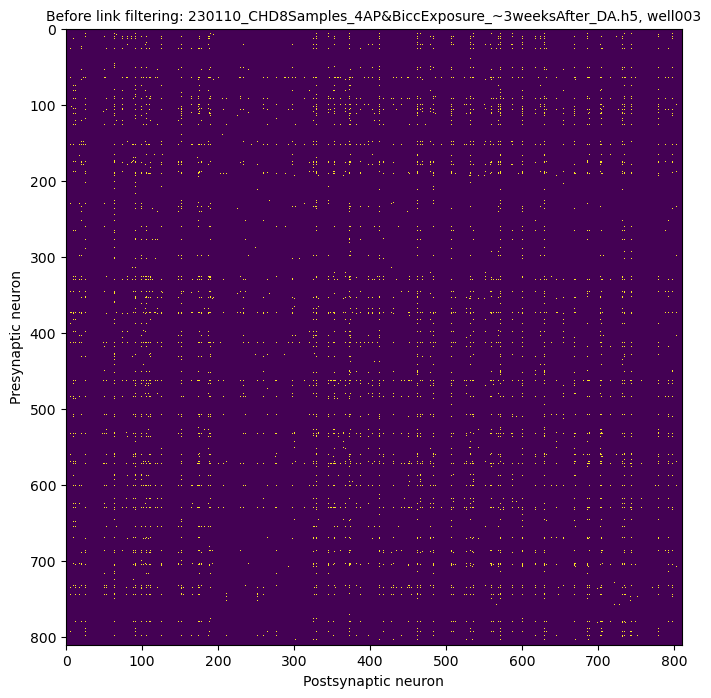

In [36]:
# Well 3 is known to have good data. We'll display the adjacency matrix
# before and after filtering likely "bad" links that are due to a global
# cause rather than a neuron-to-neuron cause (bad==correlation peaks that had
# a time delay near zero and were larger in amplitude than delayed
# correlation peaks).
#
# The 'votes' matrix is the fraction of results from the hyperparameter grid
# search that resulted in a predicted link presence. The 'adj_matrix_predicted'
# matrix is a Boolean matrix for which votes are >= data['parameters']['adj_threshold'].
# That threshold is usually set to 1.0.
well = 'well003'

adj_matrix = data[well]['adj_matrix_predicted']
votes = data[well]['votes']
corr_peaks = data[well]['corr_peaks']

fontsize = 10
plt.figure(1, figsize=(8, 8))
plt.imshow(adj_matrix, interpolation='nearest')
plt.title(f"Before link filtering: {data['source_filename']}, {well}", fontsize=fontsize)
plt.ylabel('Presynaptic neuron', fontsize=fontsize)
plt.xlabel('Postsynaptic neuron', fontsize=fontsize)

In [40]:
#sum(np.transpose(adj_matrix)!=adj_matrix)

In [38]:
adj_matrix.shape

(811, 811)

Text(0.5, 0, 'Postsynaptic neuron')

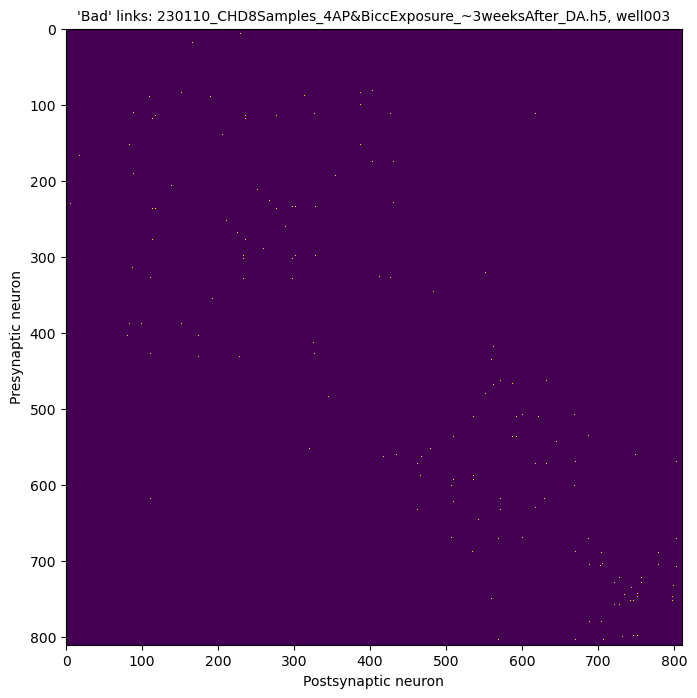

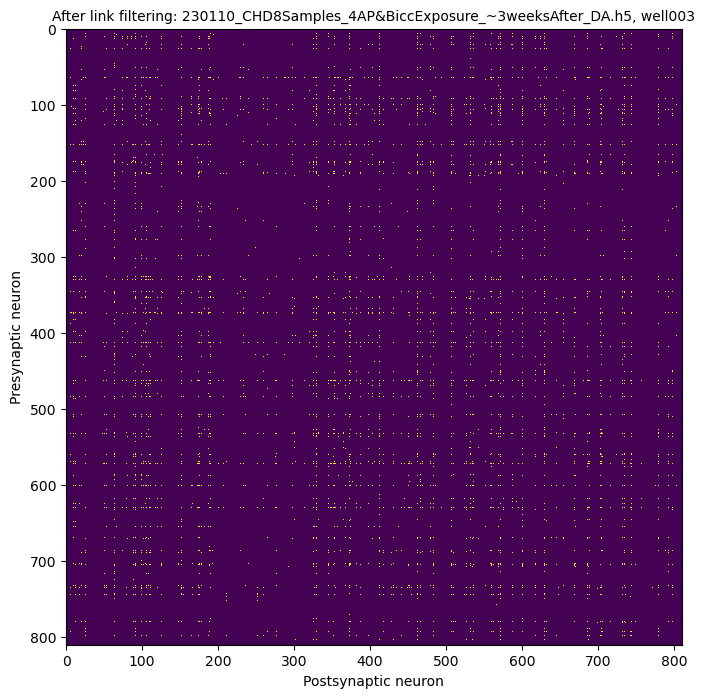

In [39]:
# Neurons pairs linked by only correlation peak delays lower than than t_res may actually
# be simultaneously stimulated by some common/global source, rather than casually linked.
# We can identify those pairs and remove their link from the adjacency matrix if we'd like to.
synced_matrix = np.full(adj_matrix.shape, False)
for key in corr_peaks.keys():
    if np.all(np.abs(np.array(corr_peaks[key]['delays'])) < data['parameters']['time_resolution']):
        synced_matrix[key[0], key[1]] = True
        synced_matrix[key[1], key[0]] = True
plt.figure(2, figsize=(8, 8))
plt.imshow(synced_matrix, interpolation='nearest')
plt.title(f"'Bad' links: {data['source_filename']}, {well}", fontsize=fontsize)
plt.ylabel('Presynaptic neuron', fontsize=fontsize)
plt.xlabel('Postsynaptic neuron', fontsize=fontsize)

filtered_matrix = np.logical_and(data[well]['adj_matrix_predicted'], np.logical_not(synced_matrix))
plt.figure(3, figsize=(8, 8))
plt.imshow(filtered_matrix, interpolation='nearest')
plt.title(f"After link filtering: {data['source_filename']}, {well}", fontsize=fontsize)
plt.ylabel('Presynaptic neuron', fontsize=fontsize)
plt.xlabel('Postsynaptic neuron', fontsize=fontsize)

In [41]:
filtered_matrix.shape

(811, 811)

In [42]:
sum(sum(filtered_matrix))

6740